<a href="https://colab.research.google.com/github/StuartLiv/CPSC-440-Project/blob/main/v0/shot0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# workflow notebook

Used reference:
-  [git in colab](https://www.geeksforgeeks.org/how-to-install-and-use-git-in-google-colab/)!

# 0. Open ipynb from github
To get this latest notebook from our repo into colab:
> "Open in colab" button == {Download from github} + {Upload to colab} - {Gets saved to drive}

# 1. Set up project in runtime
The following cell runs git config, clones the repo to get datasets as runtime files, and cds into project directory.

In [1]:
!git clone https://[token]@github.com/StuartLiv/CPSC-440-Project.git

Cloning into 'CPSC-440-Project'...
remote: Enumerating objects: 105986, done.
remote: Counting objects: 100% (63713/63713), done.
remote: Compressing objects: 100% (34878/34878), done.
remote: Total 105986 (delta 28870), reused 63670 (delta 28835), pack-reused 42273
Receiving objects: 100% (105986/105986), 376.24 MiB | 49.56 MiB/s, done.
Resolving deltas: 100% (28891/28891), done.
Updating files: 100% (105903/105903), done.


In [ ]:
!git config –global user.email “zivenanderson@msn.com”
!git config –global user.name “ZivenA”

fatal: not in a git directory
fatal: not in a git directory


In [2]:
%pwd

'/content'

`git clone` seems too good to be true for getting a few GB of data into runtime, but `/datasets/` is up once clone is run! See:

In [4]:
import os
path = '/content/CPSC-440-Project/datasets/largeset_multisize/color'
files = os.listdir(path)
print(files)

['17445.jpg', '4354.jpg', '9108.jpg', '18074.jpg', '5925.jpg', '556.jpg', '5334.jpg', '5224.jpg', '10686.jpg', '11277.jpg', '15925.jpg', '11106.jpg', '10519.jpg', '2590.jpg', '14247.jpg', '5463.jpg', '11771.jpg', '10964.jpg', '6002.jpg', '9412.jpg', '8103.jpg', '12622.jpg', '11683.jpg', '11430.jpg', '9434.jpg', '18145.jpg', '3467.jpg', '13548.jpg', '1631.jpg', '8672.jpg', '1720.jpg', '1802.jpg', '7594.jpg', '2382.jpg', '10894.jpg', '14330.jpg', '4300.jpg', '17872.jpg', '11283.jpg', '6787.jpg', '6411.jpg', '107.jpg', '16780.jpg', '4397.jpg', '13837.jpg', '7090.jpg', '10875.jpg', '11499.jpg', '9866.jpg', '2573.jpg', '7876.jpg', '4855.jpg', '854.jpg', '15527.jpg', '6845.jpg', '11147.jpg', '16537.jpg', '16019.jpg', '7337.jpg', '16150.jpg', '6746.jpg', '17739.jpg', '5483.jpg', '7856.jpg', '14111.jpg', '4683.jpg', '8798.jpg', '15865.jpg', '7235.jpg', '1705.jpg', '7953.jpg', '946.jpg', '16615.jpg', '16544.jpg', '13448.jpg', '3493.jpg', '9410.jpg', '11107.jpg', '15235.jpg', '7782.jpg', '17295.

# 2. Preprocess data

Datasets:
- `smallset_onesize` [DEPRECATED - DO NOT USE]
  - Downloaded as is, [here](https://www.kaggle.com/datasets/theblackmamba31/landscape-image-colorization).
  - 7130 color/gray pairs
  - Res 150x150
  - 0.232GB
- `largeset_multisize` [USE THIS ONE]
  - Stored in Github repo, made from combination of other datasets. Dataset construction code in repo too
  - 18329 color/gray pairs. (actually 18328 - had to delete photo 2507 due to strange resolution issues)
  - Res 128x128 (grayscale images also available in 64x64, 32x32, 16x16)
  - 401 MB



In [5]:
from tqdm import tqdm
import re
from keras.preprocessing.image import img_to_array # TODO don't use keras
import cv2 as cv


''' Returns an array containing all images in folder, sorted by filename. Useful for color/gray/downsize versions in different folders with same filename.
@param path - directory with images
@return
'''
def make_image_arr(path):

  def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)

  files = os.listdir(path)
  files = sorted_alphanumeric(files)

  arr = []
  for i in tqdm(files):
    img = cv.imread(path + '/'+i,1)
    img = img.astype('float32') / 255.0
    arr.append(img_to_array(img))

  return arr


In [6]:
color_arr = make_image_arr('/content/CPSC-440-Project/datasets/largeset_multisize/color')

100%|██████████| 18328/18328 [00:07<00:00, 2378.20it/s]


In [7]:
gray_arr = make_image_arr('/content/CPSC-440-Project/datasets/largeset_multisize/gray')

100%|██████████| 18328/18328 [00:06<00:00, 2945.27it/s]


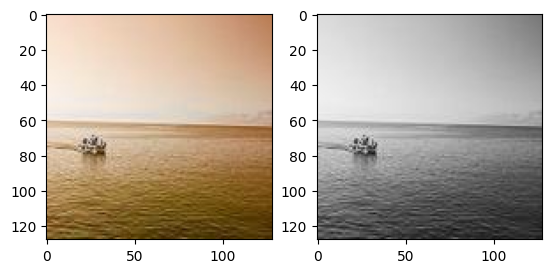

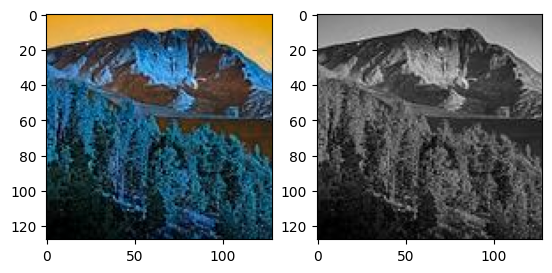

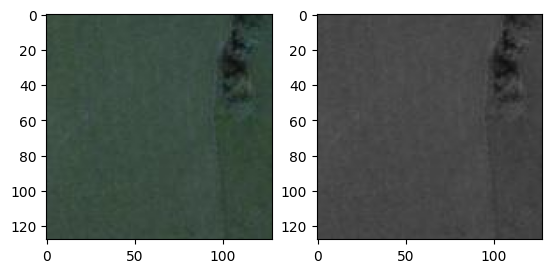

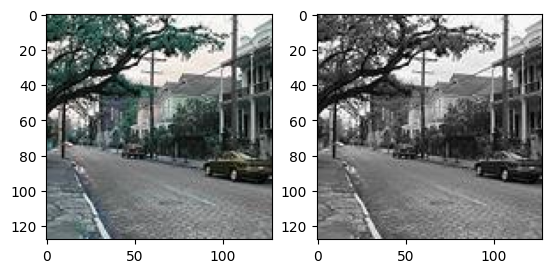

In [45]:
import matplotlib.pyplot as plt
import numpy as np

for i in np.random.randint(len(color_arr),size=4):
  plt.subplot(1,2,1)
  plt.imshow(color_arr[i])
  plt.subplot(1,2,2)
  plt.imshow(gray_arr[i])
  plt.show()

In [24]:
# Make a tensor list of reformatted images (based on Stuarts's axis swap)
import torch
gray_tensors = []

for image in gray_arr:
    # Convert each image to a PyTorch tensor
    t = torch.from_numpy(np.moveaxis(image, [2, 1], [0, 2]))
    gray_tensors.append(t)

color_tensors = []

for image in color_arr:
    # Convert each image to a PyTorch tensor
    t = torch.from_numpy(np.moveaxis(image, [2, 1], [0, 2]))
    color_tensors.append(t)

# 3. Saving new model weights to project directory

Toy model generated below:

In [31]:
# prompt: pytorch colourization autoencoder

import torch
import torch.nn as nn
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Create the autoencoder
autoencoder = Autoencoder()



Train toy model:

In [32]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Training loop
num_epochs = 3
for epoch in range(num_epochs):
    running_loss = 0.0
    for i in range(len(gray_arr)):
        if (gray_tensors[i].size() != torch.Size([3, 128, 128])):
          continue # turns out there are some non-square images (like maybe 5 or 10 total) in the original smallset dataset, and so they're here too... temporary fix

        inputs = gray_tensors[i].unsqueeze(0)  # Add batch dimension
        targets = color_tensors[i].unsqueeze(0)  # Add batch dimension

        optimizer.zero_grad()
        outputs = autoencoder(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print('[%d] loss: %.3f' % (epoch + 1, running_loss / len(gray_arr)))

print('Finished Training')

[1] loss: 0.010
[2] loss: 0.008
[3] loss: 0.008
Finished Training


input.shape (128, 128, 3)


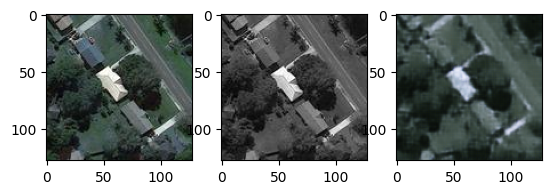

In [68]:
import random
rand_index = random.randint(0, 18000)

image_bw = gray_arr[rand_index]
image_c = color_arr[rand_index]
print(f'input.shape {image.shape}')
# Colorize the image
# plt.imshow(image)
t = torch.from_numpy(np.moveaxis(image_bw, [2, 1], [0,2]))
colorized_image = autoencoder(t)
colorized_image_format = np.moveaxis(colorized_image.detach().numpy(), [1,2], [0,1])
# plt.imshow(colorized_image_format)

plt.subplot(1,3,1)
plt.imshow(image_c)
plt.subplot(1,3,2)
plt.imshow(image_bw)
plt.subplot(1,3,3)
plt.imshow(colorized_image_format)
plt.show()

# LEFT TO RIGHT: ORIGINAL, GRAYSCALE, COLORIZED

In [21]:
torch.save(autoencoder.decoder,'/content/CPSC-440-Project/v0/decoder_weights')

In [22]:
torch.save(autoencoder.encoder,'/content/CPSC-440-Project/v0/encoder_weights')

# 4. Push changes

Look for any changes in the project directory, excluding this notebook, and push them.


In [ ]:
!git add .

fatal: not a git repository (or any of the parent directories): .git


In [ ]:
!git status

fatal: not a git repository (or any of the parent directories): .git


In [ ]:
!git commit -m "Message here"

In [ ]:
!git push

# 5. Save notebook

Commiting this notebook requires a special maneuver:

> File > Save a copy in github > enter original `path` + new commit msg

That's it!